In [1]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import IPython
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, plot, iplot
from scipy.stats import pearsonr, spearmanr
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.patches as mpatches
import os
from PIL import Image


%matplotlib inline
init_notebook_mode(connected=True)

### Due to Github not accepting our notebook because of its size, we did not include some of the maps and plots in this notebook. Please refer to the *plotly_maps* and *maps* folders and our data story.

## Drawing Maps

The following function draws a map following the provided boundaries. If a dataset is provided, it also shows the dataset value associated with each area in the map. Due to problems with Chrome, we save the map with the chosen filename, instead of visualizing it on the notebook

In [2]:
def generate_map(geo_json, location, z_vals, legend_name):
    return go.Choroplethmapbox(geojson = geo_json,
                                locations = location,
                                z = z_vals,
                                autocolorscale = True,
                                visible = False,
                                #text = [legend_name + " : " + str(round(x,2)) for x in z_vals],
                                #hoverinfo = 'location<br>text',
                                hovertemplate = "%{location}<br>" + 
                                                legend_name + " : %{z:,.2f}",     
                                name = '',
                                marker_opacity=0.7, 
                                marker_line_width=0.1)
                                #colorscale="Viridis")

# Set log to True if you want to draw the map in log scale as well
def create_map_traces(geo_json, data, log, legend_name):
    traces = []
    traces.append(generate_map(geo_json, data.index, data.values.ravel(), legend_name))
    if (log):
        traces.append(generate_map(geo_json, data.index, np.log(data.values), 'Log ' + legend_name))
        traces[-1]['visible'] = True
    else :
        traces[0]['visible'] = True
    return traces

# The number of button labels must be consistent with the number of maps
def create_map_buttons(button_labels):
    buttons = []
    for i in range(len(button_labels)):
        visible_vector = [False] * len(button_labels)
        visible_vector[i] = True
        dict_obj =  dict(label = button_labels[i],
                         method = 'update',
                         args = [{'visible': visible_vector } ,
                             #{'title': 'Yahoo High'},
                            ] )
        buttons.append(dict_obj)
    return buttons


In [5]:
def plot_map(data=None, legend_name=" ", log=False): 
    # Retrieving the geo_json in json format
    with open('data/chicago_boundaries_community_area.geojson') as f:
        community_areas_geojson = json.load(f)
    community_areas = []
    for i in range(len(community_areas_geojson['features'])):
        community_area = community_areas_geojson['features'][i]['properties']['community']
        community_areas.append(community_area)
        community_areas_geojson['features'][i]['id'] = community_area
    
    # Instanciating the map
    fig = go.Figure()
    
    # Creating traces
    map_traces = create_map_traces(community_areas_geojson, data, log, legend_name)
    
    # Creating buttons
    if (log) :
        dropdown_buttons = create_map_buttons([legend_name,"Log " + legend_name])
    else : 
        dropdown_buttons = create_map_buttons([legend_name])
        
    # Adding traces
    for trace in map_traces:
        fig.add_trace(trace)
        
    # Positioning
    fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9, mapbox_center = {"lat": 41.8523, "lon": -87.6660})
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    
    # Adding the buttons (no need in displaying them if there is only one map)
    if len(dropdown_buttons)>1 : 
        fig.update_layout(updatemenus=[
            go.layout.Updatemenu(
                 #type="buttons",
                 active = len(dropdown_buttons) - 1,
                 buttons=list(dropdown_buttons),
                 showactive=True,
                 x = 0,
                 y = 1,
                  xanchor = 'left',
                  yanchor = 'top'
                )])
    
    # Plotting
    ##iplot(fig)
    # Exporting to html
    plotly.offline.plot(fig, filename='plotly_maps/'+legend_name+'.html', auto_open=False)

In [11]:
def plot_several_maps(datas, legend_names, map_name):
    
    # Retrieving the geo_json in json format
    with open('data/chicago_boundaries_community_area.geojson') as f:
        community_areas_geojson = json.load(f)
    community_areas = []
    for i in range(len(community_areas_geojson['features'])):
        community_area = community_areas_geojson['features'][i]['properties']['community']
        community_areas.append(community_area)
        community_areas_geojson['features'][i]['id'] = community_area
    
    # Instanciating the map
    fig = go.Figure()

    # Creating traces
    map_traces = []
    for i in range(len(datas)):
        map_traces.append(generate_map(community_areas_geojson, datas[i].index, datas[i].values.ravel(), legend_names[i]))
    map_traces[-1]['visible'] = True
        
    # Creating buttons
    dropdown_buttons = create_map_buttons(legend_names)

        
    # Adding traces
    for trace in map_traces:
        fig.add_trace(trace)
        
    # Positioning
    fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9, mapbox_center = {"lat": 41.8523, "lon": -87.6660})
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    
    # Adding the buttons (no need in displaying them if there is only one map)
    if len(dropdown_buttons)>1 : 
        fig.update_layout(updatemenus=[
            go.layout.Updatemenu(
                 #type="buttons",
                 active = len(dropdown_buttons) - 1,
                 buttons=list(dropdown_buttons),
                 showactive=True,
                 x = 0,
                 y = 1,
                  xanchor = 'left',
                  yanchor = 'top'
                )])
    
    # Plotting
    iplot(fig)
    # Exporting to html
    plotly.offline.plot(fig, filename='plotly_maps/'+map_name+'.html', auto_open=False)
    

## Community Areas

This dataset was provided by the city of Chicago's government. It divides the city into community areas. Throughout our project, we use these community areas as neighborhoods about which we will present and study correlations between food quality and socio-economical variables.

In [12]:
geo_df = gpd.read_file("data/chicago_boundaries_community_area.geojson")
geo_df.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [13]:
geo_df = geo_df[["community", "shape_area", "shape_len", "geometry", "area_num_1"]]
len(geo_df)

77

In [14]:
geo_df = geo_df.rename(columns={"area_num_1": "community_number"})
geo_df["community_number"] = geo_df["community_number"].astype(int)
geo_df.head()

,community,shape_area,shape_len,geometry,community_number
0,DOUGLAS,46004621.1581,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...,35
1,OAKLAND,16913961.0408,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...,36
2,FULLER PARK,19916704.8692,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...,37
3,GRAND BOULEVARD,48492503.1554,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...,38
4,KENWOOD,29071741.9283,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...,39


In [15]:
com_number = geo_df[['community','community_number']].set_index('community')
plot_map(com_number, legend_name="Community number")

## Assigning Coordinates to Community Area

We define the following functions in order to assign a coordinate (i.e., a food inspection location) to the community area in which it is located. If a point is not inside any community area (e.g., in the boundary), we assign it to the nearest one.

In [16]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'community']

## key: key that will be used to join
def assign_community(geo_df, data, latitude="latitude", longitude="longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data, 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh['community'])]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found['community'] = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh['community'])])))
    
    columns_to_return = list(data.columns) + ["community"]
    return points_to_neigh[columns_to_return]

## Census Data

In order to normalize our results and analyze food quality prejudice by color, we also obtained information of the latest census conducted in Chicago.

In [17]:
census = pd.read_csv("data/census.csv", header=1)
census.head()

,Community,Community Number,Total Population,Age 0‐2,Age 3‐4,Age 5,Age 6‐12,Families with a child under age 6,Percent Hispanic,Percent Non‐ Hispanic Black,Percent Non‐ Hispanic White,Percent Non‐ Hispanic Asian,Percent Non‐ Hispanic Other or Multiple Races,Children 0‐5,Children 6‐17,Children 0‐5.1,Children 6‐11,Children 0‐5.2,Children 6‐11.1,Unnamed: 19
0,Rogers Park,1.0,"53,470","2,164","1,166",616,"3,819","2,708",24%,24%,45%,5%,3%,63%,61%,29%,35%,46%,70%,NaN
1,West Ridge,2.0,"75,185","3,507","2,075","1,095","7,957","4,293",20%,13%,41%,21%,4%,55%,67%,34%,40%,54%,61%,NaN
2,Uptown,3.0,"54,001","1,647",884,370,"2,681","2,053",16%,19%,51%,11%,3%,72%,61%,24%,32%,40%,70%,NaN
3,Lincoln Square,4.0,"46,881","2,163",902,324,"2,380","2,380",18%,6%,62%,10%,4%,59%,72%,14%,21%,27%,31%,NaN
4,North Center,5.0,"35,406","2,043","1,076",636,"2,873","2,468",11%,9%,73%,4%,3%,73%,77%,5%,7%,8%,15%,NaN


In [18]:
columns_to_keep = ["Community", "Total Population", "Percent Hispanic", "Percent Non‐ Hispanic Black",
                   "Percent Non‐ Hispanic White", "Percent Non‐ Hispanic Asian",
                   "Percent Non‐ Hispanic Other or Multiple Races"]
census = census[columns_to_keep]
## Renaming
census.columns = ["community", "population", "hispanic", "black", "white", "asian", "other"]
census = census.drop(census.tail(1).index)

In [19]:
races = ["hispanic", "black", "white", "asian", "other"]
census[races] = census[races].apply(lambda x: x.str.replace("%", "").astype("int32"), axis=0)
census["population"] = census["population"].str.replace(",", "").astype("int32")
census["community"] = census["community"].str.upper()
census.head()

,community,population,hispanic,black,white,asian,other
0,ROGERS PARK,53470,24,24,45,5,3
1,WEST RIDGE,75185,20,13,41,21,4
2,UPTOWN,54001,16,19,51,11,3
3,LINCOLN SQUARE,46881,18,6,62,10,4
4,NORTH CENTER,35406,11,9,73,4,3


In [20]:
census.loc[census['community'] == "O'HARE", 'community'] = 'OHARE'

In [21]:
## Check if the two dataframe indeed have the same community areas
set(geo_df["community"]) == set(census["community"])

True

In [26]:
## Census maps

population = census[['community','population']].set_index('community')
hispanic = census[['community','hispanic']].set_index('community')
black = census[['community','black']].set_index('community')
white = census[['community','white']].set_index('community')
asian = census[['community','asian']].set_index('community')
other = census[['community','other']].set_index('community')

datas = [other, hispanic, black, white, asian, population]
legend_names = ['Other races(%)', 'Hispanic population (%)', 'Black population (%)',\
               'White population (%)', 'Asian population (%)', 'Population']

#plot_several_maps(datas, legend_names, 'Census_maps1')

## Food Inspections in Chicago

The main dataset in our project contains information about food inspections in the city of Chicago from 2010 to the present. We use the results of food inspections as a proxy of food quality in a certain community.

We drop inspections from our dataset if:
* The inspection does not indicate a pass or a failure, since we cannot evaluate the food quality without this information.
* The inspection does not assign a risk to a inspections/establishment, since we cannot evaluate the food quality without this information.
* The inspection does not have a location (i.e., latitude and longitude) because we cannot assign it to a community.

In [23]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,2216009.0,Daycare Above and Under 2 Years,Risk 1 (High),1300 W 99TH ST,CHICAGO,IL,60643.0,...,Pass,NaN,41.714168,-87.655291,"{'longitude': '41.7141680989703', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,CHICAGO,IL,60647.0,...,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
2,2320328,LAS ASADAS MEXICAN GRILL,LAS ASADAS MEXICAN GRILL,2583309.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Out of Business,NaN,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
3,2320319,LA PALAPITA,LA PALAPITA,2694702.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2320228,47TH ST CANTINA,47TH ST CANTINA,2678250.0,Liquor,Risk 3 (Low),4311 W 47TH ST,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.807662,-87.731480,"{'longitude': '41.80766199360051', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [24]:
columns_to_keep = ["Inspection ID", "DBA Name", "AKA Name", 'Facility Type', "Risk", "Results", "Latitude", "Longitude", "Violations", "Inspection Date"]
inspections = inspections[columns_to_keep]
## Renaming
inspections.columns = ["inspection_id", "dba_name", "aka_name", 'Facility Type', "risk", "results", "latitude", "longitude", "violations", "date"]

In [25]:
## Mapping to redefine the risk

def map_risk(x_):
    x = str(x_)
    if "High" in x:
        return 1
    elif "Medium" in x:
        return 2
    elif "Low" in x:
        return 3
    else:
        return x
    
## Mapping to retrieve the value of the violation
    
def map_n_violations(x_):
    x = str(x_)
    if x == 'nan':
        return 0
    return len(x.split("|"))
    
## Reformating the dataframe

#convert the string date to datetime
inspections["date"] = pd.to_datetime(inspections["date"])

#eliminate rows with unknown lat/lon
inspections = inspections.dropna(subset=["latitude", "longitude"])

#only consider successful inspections
inspections = inspections[inspections["results"].isin(["Pass", "Pass w/ Conditions", "Fail"])]

#reformat the risk column
inspections["risk"] = inspections["risk"].apply(map_risk)
inspections = inspections[inspections["risk"].isin([1, 2, 3])]
inspections["risk"] = inspections["risk"].astype("int16")

#add a new column to indicate the # of violations committed during a particular inspection
inspections["n_violations"] = inspections["violations"].apply(map_n_violations)
inspections["n_violations"] = inspections["n_violations"].astype("int32")

#add the list of violations committed. may contain duplicates 
inspections['vs_committed'] = inspections.violations.apply(lambda v: [ x.split('.')[0] for x in v.split(' | ')] if type(v) == str else [])

#add the list of comments made during the inspections
inspections['vs_comments'] = inspections.violations.apply(lambda v: [ x.split('Comments: ')[1] if len(x.split('Comments: ')) == 2 else '' for x in v.split(' | ')] if type(v) == str else [])

inspections.head()

,inspection_id,dba_name,aka_name,Facility Type,risk,results,latitude,longitude,violations,date,n_violations,vs_committed,vs_comments
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,Daycare Above and Under 2 Years,1,Pass,41.714168,-87.655291,NaN,2019-10-23,0,[],[]
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,Restaurant,1,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,4,"[23, 25, 37, 47]",[OBSERVED SOME TCS FOOD NOT PROPERLY DATED IN ...
3,2320319,LA PALAPITA,LA PALAPITA,Restaurant,1,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,1,[47],"[CUTTING BOARDS WITH DEEP, DARK GROOVES. INSTD..."
4,2320228,47TH ST CANTINA,47TH ST CANTINA,Liquor,3,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3,"[3, 5, 56]",[NO EMPLOYEE HEALTH POLICY IN PLACE. INSTD TO ...
5,2320261,CRAZY BIRD,CRAZY BIRD,Restaurant,1,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,4,"[16, 23, 41, 53]",[OBSERVED LOW TEMPERATURE DISH MACHINE NOT PRO...


In [16]:
def drawPieChart(inspections_df):
    facility_counts_series = inspections_df['Facility Type'].value_counts()
    
    #gather these under 'other' category
    facility_mask = facility_counts_series < inspections_df.shape[0]* 0.017
    facility_other_count = facility_counts_series[facility_mask].sum()
    
    facility_counts_final_series = facility_counts_series[~facility_mask]
    facility_counts_final_series['Other'] =  facility_other_count
    
    labels = facility_counts_final_series.keys()
    values = facility_counts_final_series.values
    
    
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.update_layout(legend = dict(x = +0.75, ), title = 'Distribution of the Facilities Inspected')
    
    
    other_wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1000).generate_from_frequencies(dict(facility_counts_series[facility_mask]))
    return fig, other_wordcloud
fig, other_wordcloud = drawPieChart(inspections)
iplot(fig)

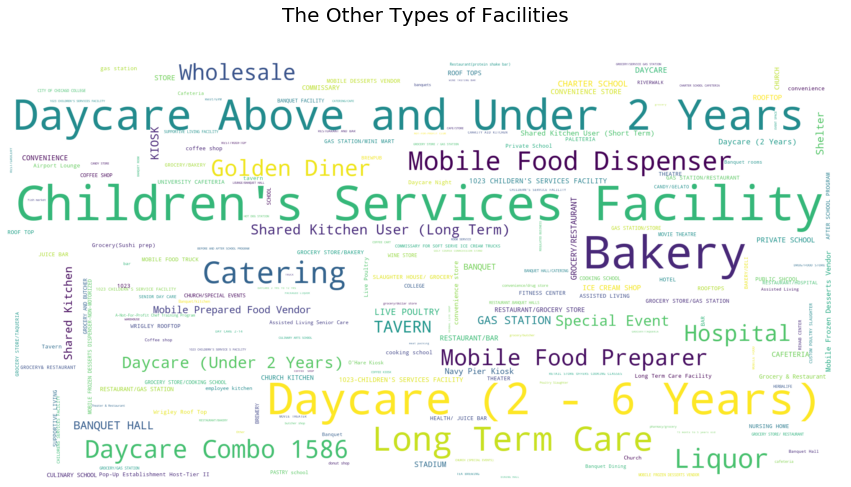

In [105]:
plt.figure(figsize = (15,15))
plt.imshow(other_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('The Other Types of Facilities', fontsize= 20, y= 1.08)
plt.show()

In [24]:
new_titles = pd.DataFrame({ "v1": "Person in charge present, demonstrates knowledge, and performs duties (1)", "v2": "City of Chicago Food Service Sanitation Certificate (2)", "v3": "Management, food employee and conditional employee; knowledge, responsibilities and reporting (3)", "v4": "Proper use of restriction and exclusion (4)", "v5": "Procedures for responding to vomiting and diarrheal events (5)", "v6": "Proper eating, tasting, drinking, or tobacco use (6)", "v7": "No discharge from eyes, nose, and mouth (7)", "v8": "Hands clean & properly washed (8)", "v9": "No bare hand contact with RTE food or a pre-approved alternative procedure properly allowed (9)", "v10": "Adequate handwashing sinks properly supplied and accessible (10)", "v11": "Food obtained from approved source (11)", "v12": "Food received at proper temperature (12)", "v13": "Food in good condition, safe, & unadulterated (13)", "v14": "Required records available: shellstock tags, parasite (14)", "v15": "Food separated and protected (15)", "v16": "Food-contact surfaces: cleaned & sanitized (16)", "v17": "Proper disposition of returned, previously served, reconditioned & unsafe food (17)", "v18": "Proper cooking time & temperatures (18)", "v19": "Proper reheating procedures for hot holding (19)", "v20": "Proper cooling time and temperature (20)", "v21": "Proper hot holding temperatures (21)", "v22": "Proper cold holding temperatures (22)", "v23": "Proper date marking and disposition (23)", "v24": "Time as a Public Health Control; procedures & records (24)", "v25": "Consumer advisory provided for raw/undercooked food (25)", "v26": "Pasteurized foods used; prohibited foods not offered (26)", "v27": "Food additives: approved and properly used (27)", "v28": "Toxic substances properly identified, stored, & used (28)", "v29": "Compliance with variance/specialized process/HACCP (29)", "v30": "Pasteurized eggs used where required (30)", "v31": "Water & ice from approved source (31)", "v32": "Variance obtained for specialized processing methods (32)", "v33": "Proper cooling methods used; adequate equipment for temperature control (33)", "v34": "Plant food properly cooked for hot holding (34)", "v35": "Approved thawing methods used (35)", "v36": "Thermometers provided & accurate (36)", "v37": "Food properly labeled; original container (37)", "v38": "Insects, rodents, & animals not present (38)", "v39": "Contamination prevented during food preparation, storage & display (39)", "v40": "Personal cleanliness (40)", "v41": "Wiping cloths: properly used & stored (41)", "v42": "Washing fruits & vegetables (42)", "v43": "In-use utensils: properly stored (43)", "v44": "Utensils, equipment & linens: properly stored, dried, & handled (44)", "v45": "Single-use/single-service articles: properly stored & used (45)", "v46": "Gloves used properly (46)", "v47": "Food & non-food contact surfaces cleanable, properly designed, constructed & used (47)", "v48": "Warewashing facilities: installed, maintained & used; test strips (48)", "v49": "Non-food contact surfaces clean (49)", "v50": "Hot & cold water available; adequate pressure (50)", "v51": "Plumbing installed; proper backflow devices (51)", "v52": "Sewage & waste water properly disposed (52)", "v53": "Toilet facilities: properly constructed, supplied, & cleaned (53)", "v54": "Garbage & refuse properly disposed; facilities maintained (54)", "v55": "Physical facilities installed, maintained & clean (55)", "v56": "Adequate ventilation & lighting; designated areas used (56)", "v57": "IN OUT All food employees have food handler training (57)", "v58": "IN OUT Allergen training as required (58)", "v59": "Previous priority foundation violation corrected (59)", "v60": "Previous core violation corrected (60)", "v61": "Summary Report displayed and visible to the public (61)", "v62": "Compliance with Clean Indoor Air Ordinance (62)", "v63": "Removal of Suspension Sign (63)", }, index=[0])
old_titles = pd.DataFrame({ "v1": "Approved food sources (1)", "v2": "Hot/cold storage facilities (2)", "v3": "Hot/cold storage temperatures (3)", "v4": "Contaminant protection (4)", "v5": "No sick handlers (5)", "v6": "Proper hand washing (6)", "v7": "Proper utensil washing (7)", "v8": "Proper sanitizing solution (8)", "v9": "Hot/cold water supply (9)", "v10": "Waste water disposal (10)", "v11": "Adequate toilet facilities (11)", "v12": "Adequate hand washing facilities (12)", "v13": "Control of rodents, other pests (13)", "v14": "Correct serious violations (14)", "v15": "No re-served food (15)", "v16": "Protection from contamination (16)", "v17": "Proper thawing (17)", "v18": "Pest control (18)", "v19": "Proper garbage area (19)", "v20": "Proper garbage storage (20)", "v21": "Oversight of hazardous food (21)", "v22": "Dishwasher maintenance (22)", "v23": "Scrape before washing (23)", "v24": "Proper dishwashers (24)", "v25": "Minimize toxic materials (25)", "v26": "Adequate customer toilets (26)", "v27": "Supplied toilet facilities (27)", "v28": "Visible inspection report (28)", "v29": "Correct minor violations (29)", "v30": "Labelled containers (30)", "v31": "Sterile utensils (31)", "v32": "Clean, maintain equipment (32)", "v33": "Clean, sanitize utensils (33)", "v34": "Clean, maintain floor (34)", "v35": "Maintain walls & ceiling (35)", "v36": "Proper lighting (36)", "v37": "Toilet rooms vented (37)", "v38": "Proper venting, plumbing (38)", "v39": "Linen, clothing storage (39)", "v40": "Proper thermometers (40)", "v41": "Clean facilities, store supplies (41)", "v42": "Ice handling, hairnets, clothes (42)", "v43": "Ice equipment storage (43)", "v44": "Restrict prep area traffic (44)", "v70": "Restrict smoking (70)" }, index=[0]) 

#the violation codes got changed after July 1st, 2018, you could check the various links to get informed

# https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/understand_healthcoderequirementsforfoodestablishments.html
# https://webapps1.chicago.gov/healthinspection/Code_Violations.jsp#summary
# https://www.chicago.gov/content/dam/city/depts/cdph/FoodProtection/ChicagoFoodCodeMajorChangesFinal2018.pdf
# https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5
# http://dev.cityofchicago.org/open%20data/data%20portal/2018/06/29/food-violations-changes.html
# https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html
# https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF

old_code_inspections = inspections[(inspections.date < pd.Timestamp(2018, 7 , 1))]
new_code_inspections = inspections[(inspections.date >= pd.Timestamp(2018, 7 , 1))]

In [81]:
#this is a helper to draw the violation distribution.

def compute_violations_matrix(inspections_df):
    
    def helper(vs_committed_list):
        values_row = pd.Series([])
        for v_number in vs_committed_list:
            index = 'v' + v_number
            values_row[index] = values_row.get(index, 0) + 1
        return values_row
            
    return inspections_df['vs_committed'].apply(helper).fillna(0)


def draw_violation_count_distribution_old(violation_matrix):
    critical_columns = [("v" + str(num)) for num in range(1, 15)]
    serious_columns = [("v" + str(num)) for num in range(15, 30)]
    minor_columns = [("v" + str(num)) for num in range(30, 45)]
    minor_columns.append("v70")

    violations_df = pd.DataFrame(violation_matrix, columns= critical_columns + serious_columns + minor_columns).rename(columns=old_titles.iloc[0])
    violations_sums = violations_df.sum()
    colors = ["red"] * 14 + ["orange"] * 15 + ["green"] *16

    violations_sums_sorted = pd.DataFrame({"sums": violations_sums, "colors": colors}).sort_values("sums")

    ax = violations_sums_sorted.sums.plot(kind="barh", color=violations_sums_sorted.colors, figsize = (10,10))
    ax.set_title("Health Code Violations", fontsize=25)
    ax.set_xlabel("Violation Count", fontsize=15)
    ax.set_ylabel('Violation Name (Code)', fontsize = 15)
    ax.invert_yaxis()
    red_patch = mpatches.Patch(color='red', label='Critical')
    orange_patch = mpatches.Patch(color='orange', label='Serious')
    green_patch = mpatches.Patch(color='green', label='Minor')
    plt.legend(handles=[red_patch, orange_patch, green_patch])
    plt.show()

In [25]:
old_codes_violation_matrix = compute_violations_matrix(old_code_inspections)
old_codes_violation_matrix['date'] = old_code_inspections.date

In [78]:
new_codes_violation_matrix = compute_violations_matrix(new_code_inspections)
new_codes_violation_matrix['date'] = new_code_inspections.date

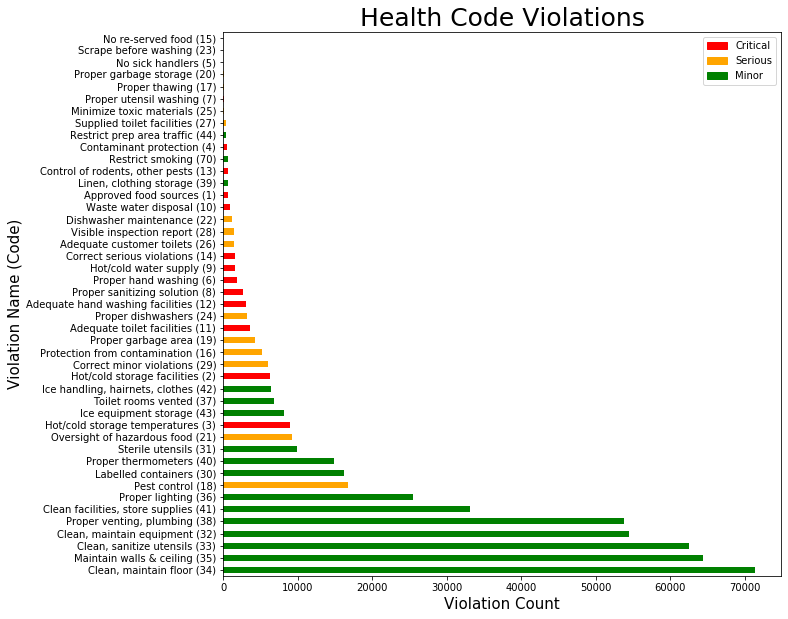

In [82]:
draw_violation_count_distribution_old(old_codes_violation_matrix)

Here we present the distribution of the violations committed. The y-axis shows the violation name with its code and the other axis shows the frequency of that particular violation. We see the majority of the violations committed are minor violations according to the categorization by Chicago Department of Public Health (CDPH). Note that CDPH changed their categorization on July 1st, 2018, so this figure is consistent with their old categorization which can be found here: https://webapps1.chicago.gov/healthinspection/Code_Violations.jsp#summary

As a result this figure covers from 2012 to 2018 July 1st.

In [86]:
def compute_treemap_values_old(old_codes_violation_matrix):

    
    #create violation df
    critical_columns = [("v" + str(num)) for num in range(1, 15)]
    serious_columns = [("v" + str(num)) for num in range(15, 30)]
    minor_columns = [("v" + str(num)) for num in range(30, 45)]
    minor_columns.append("v70")
    columns = critical_columns + serious_columns + minor_columns
    
    violations_df = pd.DataFrame(old_codes_violation_matrix, columns=columns).rename(columns = old_titles.iloc[0])
    
    #count occurences of each violation
    violations_sums = violations_df.sum()
    
    
    critical_violations_sum = violations_sums[:14].sum()
    serious_violations_sum = violations_sums[14:29].sum()
    minor_violations_sum = violations_sums[29:].sum()
    all_violations_sum = critical_violations_sum + serious_violations_sum + minor_violations_sum
    
    labels = ["Health Code Violations", "Critical", "Serious", "Minor"] + old_titles.values[0][:14].tolist() + old_titles.values[0][14:29].tolist() + old_titles.values[0][29:].tolist()
    parents = ["", "Health Code Violations", "Health Code Violations", "Health Code Violations"] + 14 * ['Critical'] + 15 * ['Serious'] + 16 * ['Minor']
    values = [all_violations_sum , critical_violations_sum, serious_violations_sum, minor_violations_sum] + violations_sums[:14].tolist() + violations_sums[14:29].tolist() + violations_sums[29:].tolist()

    
    
    return labels, parents, values

def compute_treemap_values_new(new_codes_violation_matrix): 
    violations_df = pd.DataFrame(new_codes_violation_matrix, columns=['v' + str(num) for num in range(1,64)]).rename(columns = new_titles.iloc[0])


    labels =  ['HEALTH CODE VIOLATIONS', 'FOODBORNE ILLNESS RISK FACTORS AND PUBLIC HEALTH INTERVENTIONS', 'GOOD RETAIL PRACTICES']
    parents = ["", 'HEALTH CODE VIOLATIONS', 'HEALTH CODE VIOLATIONS']
    violations_sums = violations_df.sum()
    values = [violations_sums[0:63].sum(), violations_sums[0:29].sum(), violations_sums[29:63].sum()]
    
#new_rules_cats['HEALTH CODE VIOLATIONS'] = (0, 63)
#new_rules_cats['FOODBORNE ILLNESS RISK FACTORS AND PUBLIC HEALTH INTERVENTIONS'] = (0,29)
#new_rules_cats['GOOD RETAIL PRACTICES'] = (29, 63)

    for l in list(new_rules_cats.keys()):
            t1, t2 = new_rules_cats[l]
            parents.append('GOOD RETAIL PRACTICES' if t1 >= 29 else 'FOODBORNE ILLNESS RISK FACTORS AND PUBLIC HEALTH INTERVENTIONS')
            labels.append(l)
            values.append(violations_sums[t1:t2].sum())

    for key,val in new_rules_cats.items():
        start, end = val
        labels += violations_df.columns.tolist()[start:end]
        parents += [key] * (end - start)
        values += violations_sums[start:end].values.tolist()
        
    return labels, parents, values
    

def generate_treemap(l, p, v):
    return go.Treemap(
        branchvalues = 'total',
        labels = l,
        parents = p,
        values =  v,
        textinfo = "label+value",
        #texttemplate = "%{label} <br> # of violations recorded: %{value}",
        #textinfo = "Code: %{label}",
        hoverinfo='text+percent parent+percent root+label+value',
        #hovertemplate = '%{label}',
        maxdepth=2,
        #marker_colors = ["pink", "darkred", "darkgreen", "lightgreen"]
        marker_colorscale = 'Blues',
        #textfont = {'size': 20}
        )

def create_traces():

    traces = []
    
    for year in range(2010, 2019):
        l,p,v = compute_treemap_values_old(old_codes_violation_matrix[old_codes_violation_matrix.date.dt.year == year])
        treemap = generate_treemap(l, p, v)
        traces.append(treemap)
        
    for year in range(2018, 2020):
        l,p,v = compute_treemap_values_new(new_codes_violation_matrix[new_codes_violation_matrix.date.dt.year == year])
        
        treemap = generate_treemap(l,p,v)
        traces.append(treemap)
    

    

    old_codes_treemap = generate_treemap(*compute_treemap_values_old(old_codes_violation_matrix))
    traces.append(old_codes_treemap)
    
    new_codes_treemap = generate_treemap(*compute_treemap_values_new(new_codes_violation_matrix))
    traces.append(new_codes_treemap)
    

    return traces
    
def create_dropdown_buttons(traces):
    labels = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018-old', '2018,new', '2019', 'All time old', 'All time new']
    buttons =[]
    for i in range(len(labels)):
        visible_vector = [False] * len(traces)
        visible_vector[i] = True
        
        dict_obj =  dict(label = labels[i],
                         method = 'update',
                         args = [{'visible': visible_vector } ,
                             #{'title': 'Yahoo High'},
                            ] )
        buttons.append(dict_obj)
    return buttons

def draw_treemap(traces):
    fig = go.Figure()
    
    #2010-2018old 2018new 2019new alltimeold alltimenew
    for trace in traces:
        fig.add_trace(trace)

    
    dropdown_buttons = create_dropdown_buttons(traces)
    
    fig.update_layout(updatemenus=[
        go.layout.Updatemenu(
             #type="buttons",
             active = 12,
             buttons=list(dropdown_buttons),
             showactive=True,
             x = -0.01,
             y = 1,
              xanchor = 'right',
              yanchor = 'top'
            ),
        
         go.layout.Updatemenu(
                type = "buttons",
                direction = "left",
                buttons=list([
                    dict(
                        args=["maxdepth", 2],
                        args2 = ['maxdepth', 3],
                        label="Toggle LOD",
                    ),

                ]),
                #pad={"r": 10, "t": 10},
                showactive=False,
                x=-0.01,
                xanchor="right",
                y=0.85,
                yanchor="top",
                #valign = "top"
            ),
        

        
        
            
        
    ],  annotations=[
            #go.layout.Annotation(text="Year:", showarrow=False,
            #                     x=0, y=-0.12, yref="paper", align="left"),
        
            #go.layout.Annotation(text="Depth:", showarrow=False,
            #                     x=-0.16, y=0.74, yref="paper", align="left"),
        
            #go.layout.Annotation(text="Year:", showarrow=False,
            #                     x=-0.23, y=0.96, yref="paper", align="left"),
        ])
    iplot(fig)

new_rules_cats = dict()


#new_rules_cats['HEALTH CODE VIOLATIONS'] = (0, 63)
#new_rules_cats['FOODBORNE ILLNESS RISK FACTORS AND PUBLIC HEALTH INTERVENTIONS'] = (0,29)
#new_rules_cats['GOOD RETAIL PRACTICES'] = (29, 63)

new_rules_cats['SUPERVISION'] = (0,2)
new_rules_cats['EMPLOYEE HEALTH'] = (2,5)
new_rules_cats['GOOD HYGIENIC PRACTICES'] = (5,7)
new_rules_cats['PREVENTING CONTAMINATION BY HANDS'] = (7, 10)
new_rules_cats['APPROVED SOURCE'] = (10, 14)
new_rules_cats['PROTECTION FROM CONTAMINATION'] = (14, 17)
new_rules_cats['TIME/TEMPERATURE CONTROL FOR SAFETY '] = (17, 24)
new_rules_cats['CONSUMER ADVISORY'] = (24, 25)
new_rules_cats['HIGHLY SUSCEPTIBLE POPULATIONS'] = (25, 26)
new_rules_cats['FOOD/COLOR ADDITIVES AND TOXIC SUBSTANCES'] = (26, 28)
new_rules_cats['CONFORMANCE WITH APPROVED PROCEDURES'] = (28, 29)
new_rules_cats['SAFE FOOD AND WATER'] = (29, 32)
new_rules_cats['FOOD TEMPERATURE CONTROL'] = (32, 36)
new_rules_cats['FOOD IDENTIFICATION'] = (36, 37)
new_rules_cats['PREVENTION OF FOOD CONTAMINATION  ']= (37, 42)
new_rules_cats['PROPER USE OF UTENSILS'] = (42, 46)
new_rules_cats['UTENSILS, EQUIPMENT, AND VENDING'] = (46, 49)
new_rules_cats['PHYSICAL FACILITIES'] = (49, 56)
new_rules_cats['EMPLOYEE TRAINING'] = (56, 58)
new_rules_cats['CITY OF CHICAGO ORDINANCE COMPLIANCE'] = (58, 63)

In [90]:
traces = create_traces()
draw_treemap(traces) 

The above interactive treemap is a beautiful tool to understand the violations committed during the inspections. In each cell of the treemap, the number of times a violation or a group of violations committed is written inside. When you hover a cell, the percentage with respect to the root cell, and parent cell is given.


Note that from 2012 to 2018 July 1st, the old codes apply, and then a new set of codes are in place after the specified date so the categories change. It is possible to toggle the level-of-detail with the button above, which sets the maximum depth seen from the current level to either 2 or 3.

In [97]:
all_comments = " ".join(inspections['vs_comments'].explode().fillna('').values.tolist())
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(os.path.join(d, "black-speech-bubble.png")))
comments_wordcloud = WordCloud(mask = mask, background_color = 'white').generate(all_comments)

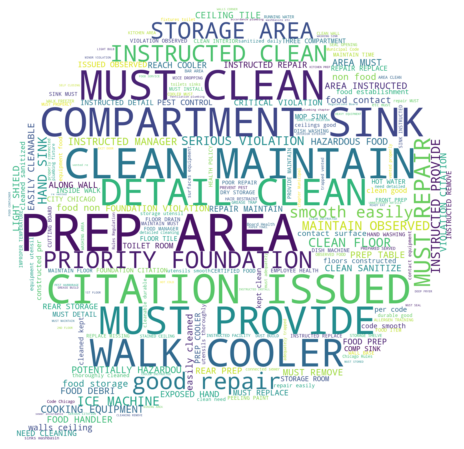

In [103]:
plt.figure(figsize = (16,8))
plt.imshow(comments_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The above wordcloud is constructed using the words appearing in the comments of the inspections. Collocations were allowed so we see 2-word sentences also. We see an importance was given to the preparation areas, compartment sink, and storage areas, for example. 

In [27]:
## Assigning the community areas
inspections_community = assign_community(geo_df, inspections, verbose=True)
inspections_community.head()

There are 2665 points without an exact neighborhood
There are 0 points without an exact neighborhood


C:\Users\Gabriel\Miniconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,inspection_id,dba_name,aka_name,Facility Type,risk,results,latitude,longitude,violations,date,n_violations,vs_committed,vs_comments,geometry,community
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,Daycare Above and Under 2 Years,1,Pass,41.714168,-87.655291,NaN,2019-10-23,0,[],[],POINT (-87.65529116028439 41.7141680989703),WASHINGTON HEIGHTS
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,Restaurant,1,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,4,"[23, 25, 37, 47]",[OBSERVED SOME TCS FOOD NOT PROPERLY DATED IN ...,POINT (-87.6822028354253 41.9135877900482),WEST TOWN
3,2320319,LA PALAPITA,LA PALAPITA,Restaurant,1,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,1,[47],"[CUTTING BOARDS WITH DEEP, DARK GROOVES. INSTD...",POINT (-87.72003743037237 41.80802515275297),ARCHER HEIGHTS
4,2320228,47TH ST CANTINA,47TH ST CANTINA,Liquor,3,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3,"[3, 5, 56]",[NO EMPLOYEE HEALTH POLICY IN PLACE. INSTD TO ...,POINT (-87.7314802731113 41.8076619936005),ARCHER HEIGHTS
5,2320261,CRAZY BIRD,CRAZY BIRD,Restaurant,1,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,4,"[16, 23, 41, 53]",[OBSERVED LOW TEMPERATURE DISH MACHINE NOT PRO...,POINT (-87.65705497652716 41.89119348444125),WEST TOWN


The following maps show:
1. The log-number of inspections in each community per 100 citizens.
2. Rate of inspection failure by community.
3. A community's average risk of an establishment adversely affecting the public’s health in the range [0, 3], with three indicating a higher risk.
4. The average number of food inspection violations in each community per 10000 citizens.
5. The number of inspections in each community normalized by number of establishments in our dataset.
6. The number of violations in each community normalized by number of establishments in our dataset.

In [28]:
population_community = census[["community", "population"]].set_index("community")["population"]
n_establishments = inspections_community.groupby("community")["dba_name"].nunique()

In [29]:
## 1) Number of inspections per capita
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
n_inspections_per_capita = n_inspections.div(population_community)
plot_map(data=n_inspections_per_capita, legend_name="Number of inspections per capita", log=True)

In [30]:
## 2) Rate of failure
neigh_results = inspections_community.groupby(["community", "results"]).count()["inspection_id"].rename("values")
percentage_results = (neigh_results.div(n_inspections) * 100).reset_index()
failure_community = percentage_results[percentage_results["results"]=="Fail"]
failure_community = failure_community.drop("results", axis="columns").set_index("community")["values"]
plot_map(data=failure_community, legend_name='Rate of failure (%)')

In [31]:
## 3) Average risk
average_risk = inspections_community.groupby("community").mean()["risk"].rename("values")
plot_map(data=average_risk, legend_name='Average risk (between 1 and 3)')

In [32]:
## 4) Number of violations per capita
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
average_violations_per_capita = average_violations.div(population_community)
plot_map(data=average_violations_per_capita, legend_name='Average number of food violations per capita', log=True)

In [33]:
## 5) Number of inspections / # establishments
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
norm_n_inspections = n_inspections.div(n_establishments)
plot_map(data=norm_n_inspections, legend_name='Normalized Number of inspections per establishment')

In [34]:
## 6) Number of violations / # establishments
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
norm_average_violations = average_violations.div(n_establishments)
plot_map(data=norm_average_violations, legend_name='Normalized Number of food violations per establishment', log=True)

In [35]:
## All the food inspection maps reunited
datas = [#n_inspections_per_capita,\
         np.log(n_inspections_per_capita),\
         failure_community, average_risk,\
         #average_violations_per_capita,\
         np.log(average_violations_per_capita),\
         norm_n_inspections,\
         #norm_average_violations,\
         np.log(norm_average_violations)]
legend_names = ["Number of inspections per capita",\
                "Log-number of inspections per capita",\
                "Rate of failure (%)", "Average risk (between 1 and 3)",\
                "Number of food violations per capita",\
                "Log-number of food violations per capita",\
                "Number of inspections per establishment",\
                "Number of food violations per establishment",\
                "Log-number of food violations per establishment"]

#plot_several_maps(datas, legend_names, "Food_inspections_maps")


We can see through these maps that the food is indeed not of the same quality across all community areas.

## Hardship Index

The city of Chicago also makes available the economic hardship of all its community areas. The economic hardship index is a function of:

1. Unemployment (over the age of 16 years),
2. Education (over 25 years of age without a high school
diploma)
3. Per capita income level
4. Poverty (below the federal poverty level)
5. Crowded housing (housing units with more than one person
per room)
6. Dependency (population under 18 or over 64 years of age)

We will use the economic hardship index as a measurement of economic conditions of each community area in Chicago. A higher index indicates poorer conditions. For more information on the index: https://greatcities.uic.edu/wp-content/uploads/2016/07/GCI-Hardship-Index-Fact-SheetV2.pdf

In [36]:
income_df = pd.read_csv("data/Per_Capita_Income.csv")
income_df.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [37]:
## Renaming
income_df.columns = ['community_number','community','percentage_housing_crowded','percent_households_below_poverty','percent_aged_16+_unemployed','percent_aged_25+_without_highschool_diploma','percent_aged_under_18_or_over_64','per_capita_income','hardship_index']
income_df["community"].unique

<bound method Series.unique of 0         Rogers Park
1          West Ridge
2              Uptown
3      Lincoln Square
4        North Center
           ...       
73    Mount Greenwood
74        Morgan Park
75             O'Hare
76          Edgewater
77            CHICAGO
Name: community, Length: 78, dtype: object>

In [38]:
## Getting rid of the non relevant last row
income_df = income_df[income_df["community"] != 'CHICAGO']
## Reformating the community area names
income_df["community"] = income_df["community"].str.upper()

In [39]:
## Checking if the income dataframe has the same community areas as the geojson dataframe
set(geo_df["community"]) == set(income_df["community"])

False

In [40]:
## Displaying the differences
set(geo_df["community"]) - set(income_df["community"])

{'MONTCLARE', 'OHARE', 'WASHINGTON HEIGHTS'}

In [41]:
set(income_df["community"]) - set(geo_df["community"])

{'MONTCLAIRE', "O'HARE", 'WASHINGTON HEIGHT'}

In [42]:
## Correcting the issue 
income_df.loc[income_df['community'] == "O'HARE", 'community'] = 'OHARE'
income_df.loc[income_df['community'] == "MONTCLAIRE", 'community'] = 'MONTCLARE'
income_df.loc[income_df['community'] == "WASHINGTON HEIGHT", 'community'] = 'WASHINGTON HEIGHTS'
## Checking if the income dataframe has the same community areas
set(geo_df["community"]) == set(income_df["community"])

True

We normalize hardship into a [0, 1] range for our analysis. Since hardship is not a concept easy to understand as it is a function of many economic variables, we believe that comparing between communities will be easier after normalizing the index.

In [43]:
delta_hardship = income_df["hardship_index"].max() - income_df["hardship_index"].min()
income_df["hardship_index"] = (income_df["hardship_index"] - income_df["hardship_index"].min())/delta_hardship

In [44]:
hardship = income_df[["community", "hardship_index"]].set_index("community").rename(columns={"hardship_index": "values"})["values"]
#plot_map(data=hardship, legend_name='Hardship Index')

### 1) Correlation Between Race and Food Quality

Since each community areas has a dominant race, and that food quality varies from one community to another, we speculate that the food quality may vary depending on the race.

In [45]:
def plot_correlation_food_variables(food_quality_index=None, index_name="",
                                    variables_df=None, variables=None, variable_name="", method="pearson"):
    correlations = []
    for var in variables:
        var_community = variables_df[["community", var]].set_index("community")[var]
        correlations.append(var_community.corr(food_quality_index, method=method))
    plt.bar(x=variables, height=correlations)
    plt.title("Correlation between {} and {}".format(variable_name, index_name))

In [46]:
def scatter_plot(food_quality_index=None, index_name="",
                           variable_df=None, variable_name="", method="pearson"):
    plt.ylabel(index_name)
    plt.xlabel(variable_name)
    plt.scatter(variable_df, food_quality_index)

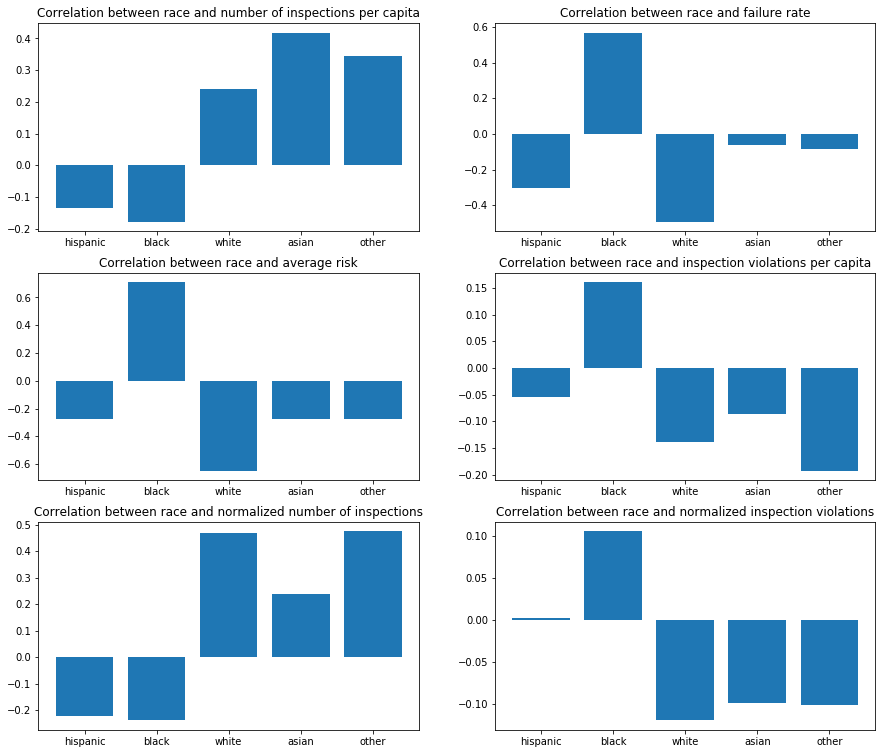

In [47]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
plot_correlation_food_variables(n_inspections_per_capita, index_name="number of inspections per capita",
                                variables_df=census, variables=races, variable_name="race")

## 2) Rate of failure
plt.subplot(3, 2, 2)
plot_correlation_food_variables(failure_community, index_name="failure rate",
                                variables_df=census, variables=races, variable_name="race")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
plot_correlation_food_variables(average_risk, index_name="average risk",
                                variables_df=census, variables=races, variable_name="race")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
plot_correlation_food_variables(average_violations_per_capita, index_name="inspection violations per capita",
                                variables_df=census, variables=races, variable_name="race")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
plot_correlation_food_variables(norm_n_inspections, index_name="normalized number of inspections",
                                variables_df=census, variables=races, variable_name="race")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
plot_correlation_food_variables(norm_average_violations, index_name="normalized inspection violations",
                                variables_df=census, variables=races, variable_name="race")

Apparently, the black population lives in community areas with lower quality of food, a higher number of inspection violations, a lower number of inspections as well as a higher risk.

On the other hand, it is the complete opposite for the white population: they have higher quality of food, a lower number of inspection violations, a higher number of inspections and a lower value of risk.

In [48]:
# If we use this function, we shouldn't use the buttons
def add_plot_trace_with_legend_without_corr(traces, food_quality_index=None, index_name="",
                           variable_df=None, variable_name="",):
    traces.append(go.Scatter(x=variable_df, 
                             y=food_quality_index,
                             mode='markers',
                             #text = [index_name + " : \n" + str(round(y,3)) for y in food_quality_index],
                             #hoverinfo = 'text',
                             hovertemplate = index_name + " : %{y:,.3f}<br>" + 
                                             variable_name + " : %{x}%",
                             name=index_name,
                             showlegend = True,
                             marker_color=food_quality_index))
    traces[-1]['visible'] = 'legendonly'
    return traces

def add_plot_trace_without_corr(traces, food_quality_index=None, index_name="",
                           variable_df=None, variable_name="",):
    traces.append(go.Scatter(x=variable_df, 
                             y=food_quality_index,
                             mode='markers',
                             #text = [index_name + " : \n" + str(round(y,3)) for y in food_quality_index],
                             #hoverinfo = 'text',
                             hovertemplate = index_name + " : %{y:,.3f}<br>" + 
                                             variable_name + " : %{x}%",
                             name='',
                             marker_color=food_quality_index))
    traces[-1]['visible'] = False
    return traces

In [49]:
def add_plot_trace(traces, food_quality_index=None, index_name="",
                           variable_df=None, variable_name="",):
    corr_p, pval_p = pearsonr(food_quality_index, variable_df)
    if pval_p<0.05:
        p_sgn = "Significant"
    else :
        p_sgn = "Not Significant"
    corr_s, pval_s = spearmanr(food_quality_index, variable_df)
    if pval_s<0.05:
        s_sgn = "Significant"
    else :
        s_sgn = "Not Significant"
    percentage = "%" if "Percentage" in variable_name else ""
    traces.append(go.Scatter(x=variable_df, 
                             y=food_quality_index,
                             mode='markers',
                                 hovertemplate = index_name + " : %{y:,.3f}<br>" + 
                                                 variable_name + " : %{x}" + percentage,
                             name="<b>Correlations :</b><br>" +
                                 "<i>Pearson's</i> : <br>" + 
                                 "Value : " + str(round(corr_p,2)) + ", P-value : " + str(round(pval_p,2)) + ", <b>" + p_sgn + "</b><br>" +
                                 "<i>Spearman's</i> : <br>" + 
                                 "Value : " + str(round(corr_s,2)) + ", P-value : " + str(round(pval_s,2)) + ", <b>" + s_sgn + "</b><br>",
                             marker_color=food_quality_index))
    traces[-1]['visible'] = False
    return traces

In [50]:
def create_plot_buttons(button_labels):
    buttons = []
    #name = ['okok','okok2','okok3','okok4','okok5','okok6']
    for i in range(len(button_labels)):
        visible_vector = [False] * len(button_labels)
        visible_vector[i] = True
        dict_obj =  dict(label = button_labels[i],
                         method = 'update',
                         #name = name[i],
                         args = [{'visible': visible_vector } ,
                         #{'title': 'Yahoo High'},
                            ] )
        buttons.append(dict_obj)
    return buttons  

In [51]:
def create_scatter_plots(corr_variable, corr_variable_name, plot_name):
    # Instanciating the figure
    fig = go.Figure()

    # Creating traces
    scatter_traces = []
    ## 1) Number of inspections per capita
    scatter_traces = add_plot_trace(scatter_traces, n_inspections_per_capita, index_name="Number of inspections per capita",
                                variable_df=corr_variable, variable_name=corr_variable_name)
    ## 2) Rate of failure
    scatter_traces = add_plot_trace(scatter_traces, failure_community, index_name="Failure rate (%)",
                                variable_df=corr_variable, variable_name=corr_variable_name)
    ## 3) Average risk
    scatter_traces = add_plot_trace(scatter_traces, average_risk, index_name="Average risk (1-3)",
                                variable_df=corr_variable, variable_name=corr_variable_name)
    ## 4) Number of violations per capita
    scatter_traces = add_plot_trace(scatter_traces, average_violations_per_capita, index_name="Inspection violations per capita",
                                variable_df=corr_variable, variable_name=corr_variable_name)
    ## 5) # inspections / # establishments
    scatter_traces = add_plot_trace(scatter_traces, norm_n_inspections, index_name="Normalized number of inspections",
                                variable_df=corr_variable, variable_name=corr_variable_name)
    ## 6) # violations / # establishments
    scatter_traces = add_plot_trace(scatter_traces, norm_average_violations, index_name="Normalized inspection violations",
                                variable_df=corr_variable, variable_name=corr_variable_name)

    scatter_plot_titles = ['Number of nspections per capita',
                           'Failure rate (%)',
                           'Average risk (1-3)',
                           'Number of inspection violations per capita',
                           'Number of inspections per establishment',
                           'Number of inspection violations per establishment']

    # Rendering the last scatter plot visible
    scatter_traces[-1]['visible'] = True

    # Creating buttons
    dropdown_buttons = create_plot_buttons(scatter_plot_titles)

    # Adding traces
    for trace in scatter_traces:
        fig.add_trace(trace)

    # Adding the buttons 
    fig.update_layout(
        xaxis = dict(title = corr_variable_name),
        title = dict(text = "<b>Food quality index / " + corr_variable_name + "</b>", x=0.5),
        updatemenus=[
        go.layout.Updatemenu(
             active = len(dropdown_buttons) - 1,
             buttons = list(dropdown_buttons),
             showactive=True,
             x = 0,
             y = 1.1,#Change to 1 if you want to display it on the top left corner inside the plot
              xanchor = 'left',
              yanchor = 'top'
            )])

    # Plotting
    iplot(fig)

    # Exporting the plot to html
    plotly.offline.plot(fig, filename='plotly_maps/'+ plot_name + '.html', auto_open=False)

In [63]:
# Black population scatter plots
create_scatter_plots(census["black"], "Percentage of black population", "black_scatter_plots")

Unfortunately the scatterplots don't show any correlation. We'll then proceed with a significance test of our correlation index. Note that some of them have a range that is hard to work with. We will then conduct both a pearson and spearman correlation tests to check whether they are correlated.

In [58]:
def correlation_and_pvalue(x_dict,y):
    for x in x_dict:
        corr_p, pval_p = pearsonr(x["data"], y)
        corr_s, pval_s = spearmanr(x["data"], y)
        print(x["name"])
        print("Pearson   r={}, p-value={}\t{}".format(corr_p, pval_p, "Significant" if pval_p < 0.05 else "Not significant"))
        print("Spearman  r={}, p-value={}\t{}\n".format(corr_s, pval_s, "Significant" if pval_s< 0.05 else "Not significant"))
        
variables_list = [
    {"name": "N Inspection Per Capita", "data": n_inspections_per_capita},
    {"name": "Failure Rate", "data": failure_community},
    {"name": "Average Risk", "data": average_risk},
    {"name": "N Violations Per Capita", "data": average_violations_per_capita},
    {"name": "N Inspection Per Establishment", "data": norm_n_inspections},
    {"name": "N Violations Per Establishment", "data": norm_average_violations}
]

In [59]:
correlation_and_pvalue(variables_list, census["black"])

N Inspection Per Capita
Pearson   r=0.20996003722322482, p-value=0.06684069858994482	Not significant
Spearman  r=0.35452288767371887, p-value=0.001559008648266582	Significant

Failure Rate
Pearson   r=-0.02130681694271938, p-value=0.8540689063083394	Not significant
Spearman  r=0.019126424944439436, p-value=0.868862423701974	Not significant

Average Risk
Pearson   r=-0.2050441008276864, p-value=0.07363339643252736	Not significant
Spearman  r=-0.24392111261674035, p-value=0.03253347328988301	Significant

N Violations Per Capita
Pearson   r=-0.07602729783525088, p-value=0.5110670948717069	Not significant
Spearman  r=-0.09318541561651235, p-value=0.4201965979786848	Not significant

N Inspection Per Establishment
Pearson   r=0.06268847785396406, p-value=0.5880769475379856	Not significant
Spearman  r=0.11098325120786487, p-value=0.33659351935887505	Not significant

N Violations Per Establishment
Pearson   r=-0.14091215111858957, p-value=0.22156227151711447	Not significant
Spearman  r=-0.1731

In [60]:
correlation_and_pvalue(variables_list, census["white"])

N Inspection Per Capita
Pearson   r=-0.12883052051833657, p-value=0.2641425010218123	Not significant
Spearman  r=-0.2261066687494175, p-value=0.04800621350237505	Significant

Failure Rate
Pearson   r=0.013842217750634097, p-value=0.9048919636881911	Not significant
Spearman  r=0.04335103136513758, p-value=0.7081381308096459	Not significant

Average Risk
Pearson   r=0.19700993577552048, p-value=0.08591452796477711	Not significant
Spearman  r=0.19956468413326228, p-value=0.08184496259919131	Not significant

N Violations Per Capita
Pearson   r=0.05517058703647182, p-value=0.6336721040558431	Not significant
Spearman  r=-0.04392974658967218, p-value=0.7044204728211103	Not significant

N Inspection Per Establishment
Pearson   r=-0.10645470574051476, p-value=0.3568002856579901	Not significant
Spearman  r=-0.1260546979986282, p-value=0.27465836168262914	Not significant

N Violations Per Establishment
Pearson   r=0.13286671143097337, p-value=0.24934302944514894	Not significant
Spearman  r=-0.002

There is a significant correlation between number of inspections between race composition of a community and number of inspections. The relation, however, does not seem to be linear. 
- The more black people there is in a community, the higher the number of inspections per capita in that community. The opposite trend is found for white people.

### 2) Correlation Between Hardship and Food Quality

The higher the hardship index is, the lower are the educational and income level.
We then speculate that the higher the educational and income level, the higher is the food quality.

In [61]:
# Hardship scatter plots
create_scatter_plots(hardship, "Hardship", "Hardship_scatter_plots")

Unfortunately, these scatter plots seem to prove the initial assumption wrong: there doesn't seem to be any correlation between the hardship and the food quality.

In [62]:
correlation_and_pvalue(variables_list, hardship)

N Inspection Per Capita
Pearson   r=0.043029841746080266, p-value=0.7102043994496091	Not significant
Spearman  r=0.04945054945054945, p-value=0.6693131929898244	Not significant

Failure Rate
Pearson   r=0.0227341825900151, p-value=0.8444113485786257	Not significant
Spearman  r=0.008596666491403332, p-value=0.940848903103034	Not significant

Average Risk
Pearson   r=-0.14930707667689647, p-value=0.19497103231168783	Not significant
Spearman  r=-0.15636994584363004, p-value=0.17444206081441707	Not significant

N Violations Per Capita
Pearson   r=0.03691595181805692, p-value=0.7499188146908523	Not significant
Spearman  r=0.19533098480466898, p-value=0.08867510592071373	Not significant

N Inspection Per Establishment
Pearson   r=0.19413458033201705, p-value=0.09068465604724686	Not significant
Spearman  r=0.21244544928755454, p-value=0.06360406956510414	Not significant

N Violations Per Establishment
Pearson   r=-0.0641062972212598, p-value=0.579647445768976	Not significant
Spearman  r=0.184

No correlation is significant according to the p-values obtained.

# Crime Dataset Investigation

In [64]:
crime_df = pd.read_csv('data/Crimes_2001-2019.csv')
crime_df.head()

C:\Users\Gabriel\Miniconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


Limit the data to the period 2010-2019

In [65]:
crime_df = crime_df.loc[crime_df.Year>2009]
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [66]:
crime_df['Primary Type'].unique()

array(['CRIM SEXUAL ASSAULT', 'BURGLARY', 'THEFT',
       'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'CRIMINAL DAMAGE', 'OTHER OFFENSE', 'SEX OFFENSE', 'ASSAULT',
       'NARCOTICS', 'ROBBERY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION',
       'MOTOR VEHICLE THEFT', 'BATTERY', 'OBSCENITY',
       'LIQUOR LAW VIOLATION', 'PROSTITUTION', 'NON-CRIMINAL',
       'PUBLIC PEACE VIOLATION', 'INTIMIDATION', 'ARSON', 'STALKING',
       'INTERFERENCE WITH PUBLIC OFFICER',
       'CONCEALED CARRY LICENSE VIOLATION', 'KIDNAPPING',
       'HUMAN TRAFFICKING', 'HOMICIDE', 'GAMBLING', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

Some types of violation can be excluded for some resons:
- Liquor law violation is not an index of a dangerous neighborhood
- Non-criminal actions are used to code police calls that are not crimes
- Concealed carry license violations are assigned to a vehicle in movement so we can not connect the place where is found to its original neighborhood

In [67]:
crime_df = crime_df[~crime_df['Primary Type'].isin(['LIQUOR LAW VIOLATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)'])]
crime_df.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,...,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
10,11227586,JB147613,02/10/2017 12:00:00 PM,089XX S COTTAGE GROVE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,8.0,44.0,14,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [68]:
crime_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [69]:
crime_df['Location']

1                                    NaN
2                                    NaN
3                                    NaN
4                                    NaN
5                                    NaN
                       ...              
7001558    (41.862830429, -87.717040084)
7001559    (41.864278228, -87.659660218)
7001560    (41.864278357, -87.659682244)
7001561                              NaN
7001562                              NaN
Name: Location, Length: 2920357, dtype: object

Note that community area 0 is not a real community area. It is an outlier which (we hypothesize) indicates crimes in areas around Chicago. Also, there is no community area with number 0 in the GeoJson file provided by the city of Chicago.

We will finally assign the community area where the crime was commited by comparing the *community_number* column of the GeoJson.

In [70]:
crime_df["Community Area"].value_counts()

25.0    184194
8.0     108276
43.0     97658
29.0     92724
23.0     92591
         ...  
74.0      6378
12.0      5254
47.0      4186
9.0       2833
0.0         26
Name: Community Area, Length: 78, dtype: int64

In [71]:
crime_df.drop(['ID', 'Case Number', 'Domestic', 'Beat', 'Ward', 'FBI Code', 'Updated On', 'Block', 'Description', 'Location Description', 'Arrest', 'IUCR', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
crime_df = crime_df[crime_df["Community Area"] != 0.0]

In [72]:
crime_df.head()

,Date,Primary Type,District,Community Area,Year,Latitude,Longitude
1,10/08/2017 03:00:00 AM,CRIM SEXUAL ASSAULT,22.0,73.0,2017,NaN,NaN
2,03/28/2017 02:00:00 PM,BURGLARY,8.0,70.0,2017,NaN,NaN
3,09/09/2017 08:17:00 PM,THEFT,3.0,42.0,2017,NaN,NaN
4,08/26/2017 10:00:00 AM,CRIM SEXUAL ASSAULT,1.0,32.0,2017,NaN,NaN
5,02/10/2013 12:00:00 AM,CRIM SEXUAL ASSAULT,7.0,69.0,2013,NaN,NaN


In [73]:
crimes_by_community = crime_df.groupby('Community Area').count()['Date'].rename('values')
crimes_by_community.index = geo_df.sort_values("community_number")["community"]
crimes_by_community

community
ROGERS PARK           42347
WEST RIDGE            36848
UPTOWN                40085
LINCOLN SQUARE        20435
NORTH CENTER          15734
                      ...  
WASHINGTON HEIGHTS    35086
MOUNT GREENWOOD        6378
MORGAN PARK           23328
OHARE                 17850
EDGEWATER             27439
Name: values, Length: 77, dtype: int64

In [74]:
criminality = crimes_by_community.div(population_community)
criminality

community
ROGERS PARK           0.791977
WEST RIDGE            0.490098
UPTOWN                0.742301
LINCOLN SQUARE        0.435891
NORTH CENTER          0.444388
                        ...   
WASHINGTON HEIGHTS    1.250303
MOUNT GREENWOOD       0.377888
MORGAN PARK           0.976067
OHARE                 1.746234
EDGEWATER             0.485337
Length: 77, dtype: float64

In [75]:
plot_map(data=criminality, legend_name="Crimes per capita")

The map shows 2 areas composed by more communities that have more criminality, there is some overlapping between these areas and the parts where there are more food violations

In [76]:
correlation_and_pvalue(variables_list, criminality)

N Inspection Per Capita
Pearson   r=0.08752787537323214, p-value=0.44908230623097833	Not significant
Spearman  r=0.21528471528471527, p-value=0.06006311840269572	Not significant

Failure Rate
Pearson   r=0.04826662587260089, p-value=0.6767855789109088	Not significant
Spearman  r=-0.02450181397549818, p-value=0.8324833906836078	Not significant

Average Risk
Pearson   r=-0.1518491658641965, p-value=0.18739113604147886	Not significant
Spearman  r=-0.21489037278510958, p-value=0.06054511950640011	Not significant

N Violations Per Capita
Pearson   r=0.05916357701577481, p-value=0.6092706585840568	Not significant
Spearman  r=0.05999263894000736, p-value=0.6042559847549425	Not significant

N Inspection Per Establishment
Pearson   r=0.07224889914960352, p-value=0.5323460624471417	Not significant
Spearman  r=0.13386613386613386, p-value=0.24576794568338317	Not significant

N Violations Per Establishment
Pearson   r=-0.07668399005468927, p-value=0.5074137089839523	Not significant
Spearman  r=0.0

Our results show that there is no significant correlation between criminality and food quality. We also plot the scatter plots for visualization.

In [77]:
# Criminality scatter plots
create_scatter_plots(criminality, "Crimes per capita", "crimes_scatter_plots")

## Time correlation between food inspection and crimes

In [78]:
inspections['year'] = inspections['date'].dt.year
df_inspections_per_year = inspections.groupby(['year']).count()
df_inspections_per_year.head(10)

,inspection_id,dba_name,aka_name,Facility Type,risk,results,latitude,longitude,violations,date,n_violations,vs_committed,vs_comments,geometry
year,,,,,,,,,,,,,,
2010,17301,17301,16963,16899,17301,17301,17301,17301,12418,17301,17301,17301,17301,17301
2011,17507,17507,17222,17444,17507,17507,17507,17507,13428,17507,17507,17507,17507,17507
2012,15943,15943,15678,15899,15943,15943,15943,15943,13258,15943,15943,15943,15943,15943
2013,17020,17020,16745,17004,17020,17020,17020,17020,14685,17020,17020,17020,17020,17020
2014,18561,18561,18375,18530,18561,18561,18561,18561,16238,18561,18561,18561,18561,18561
2015,17833,17833,17662,17816,17833,17833,17833,17833,15574,17833,17833,17833,17833,17833
2016,19789,19789,19705,19777,19789,19789,19789,19789,17136,19789,19789,19789,19789,19789
2017,18416,18416,18355,18399,18416,18416,18416,18416,15717,18416,18416,18416,18416,18416
2018,14774,14774,14746,14754,14774,14774,14774,14774,12938,14774,14774,14774,14774,14774


In [79]:
df_crime_per_year = crime_df.groupby(['Year']).count()
df_crime_per_year.head(10)

,Date,Primary Type,District,Community Area,Latitude,Longitude
Year,,,,,,
2010,369616,369616,369616,369430,369257,369257
2011,351198,351198,351198,351017,350679,350679
2012,335470,335470,335470,335444,334853,334853
2013,306709,306709,306709,306705,305879,305879
2014,274962,274962,274962,274962,273276,273276
2015,263898,263898,263898,263898,257534,257534
2016,268901,268901,268901,268901,266907,266907
2017,268097,268097,268096,268097,264623,264623
2018,267123,267123,267123,267121,262972,262972


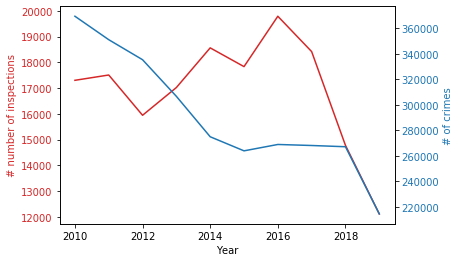

In [80]:
#plt.plot(df_inspections_per_year.index, df_inspections_per_year['n_violations'])
#plt.plot(df_inspections_per_year.index, df_crime_per_year['Primary Type'])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('# number of inspections', color=color)
ax1.plot(df_inspections_per_year.index, df_inspections_per_year['n_violations'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of crimes', color=color)  # we already handled the x-label with ax1
ax2.plot(df_inspections_per_year.index, df_crime_per_year['Primary Type'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [81]:
corr_lin, p_lin = pearsonr(df_inspections_per_year['n_violations'],df_crime_per_year['Primary Type'])
corr, p = spearmanr(df_inspections_per_year['n_violations'],df_crime_per_year['Primary Type'])

In [82]:
print('Pearson corr:', corr_lin, ' p-val:',p_lin)
print('Spearman corr', corr, 'p-val',p)

Pearson corr: 0.3131580387056231  p-val: 0.37828598450029044
Spearman corr 0.12727272727272726 p-val 0.7260570147627894
